### Tema d'esame 2021-11-17: *Analisi Dati in Fisica Subnucleare*

# Caratterizzazione della risoluzione temporale di un rivelatore

I rivelatori al semiconduttore sono ampiamente utilizzati negli esperimenti di Fisica Subnucleare per realizzare tracciatori con elevata risoluzione spaziale.
Recentemente, si è aperto un campo di studio sulla risoluzione temporale dei rivelatori al semiconduttore per costruire tracciatori 4D, che ricostruiscano la traiettoria delle particelle nello spazio-tempo, così da consentire la ricostruzione di molte più tracce simultanee.

In questo tema studieremo la risoluzione temporale di un rivelatore a pixel realizzato in diamante, di cui è mostrato un esempio nella figura sotto.




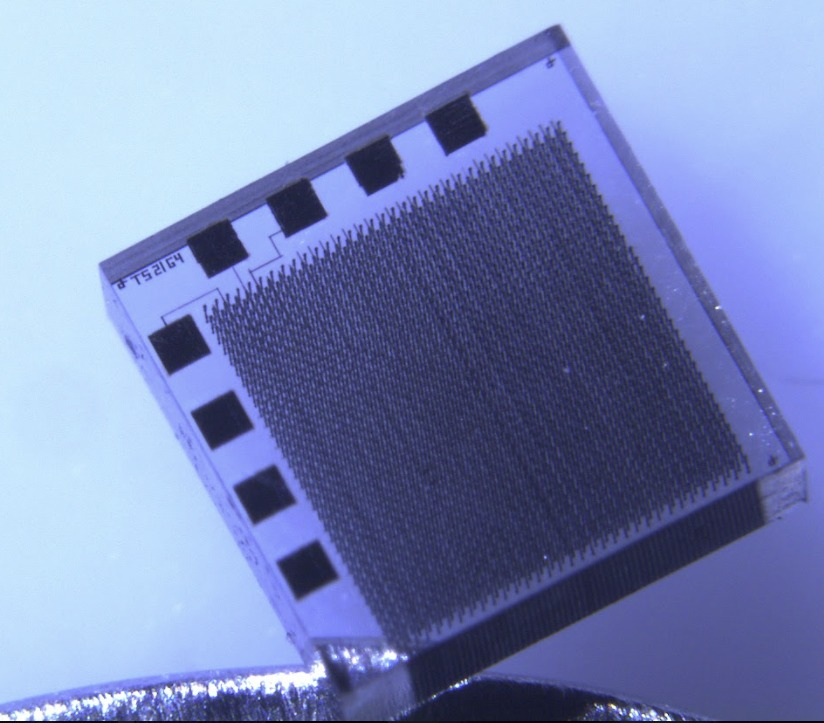

I dati analizzati in questo esercizio sono stati ottenuti ad un beam test presso l'acceleratore SPS al CERN, con un fascio di adroni a 180 GeV/$c$.

I dati sono stati preparati per l'esercizio calcolando ampiezza ed intervallo temporale tra un trigger esterno e il segnale ottenuto dal rivelatore al diamante.

**Nota!**
Questo esercizio si può risolvere con celle non più lunghe di 20 righe di codice. Se la vostra soluzione richiede di scrivere molto più codice, forse avete scelto un approccio inutilmente complicato.

## Caricamento di librerie e dataset
Per questo esercizio utilizzeremo:
 * numpy,
 * pandas
 * matplotlib
 * iminuit

Quest'ultimo deve essere scaricato da pypi perché normalmente non disponibile su Google Colab.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install iminuit
from iminuit import Minuit

     |████████████████████████████████| 334 kB 31.0 MB/s 


Il dataset è rilasciato in formato `csv`, e può essere scaricato da pandora all'indirizzo:
https://pandora.infn.it/public/4310a5/dl/timing-detector.csv

Il dataset contiene una colonna `amplitude` che rappresenta l'ampiezza del segnale di diamante ed una colonne `time` che rappresenta il ritardo tra l'istante temporale in cui è registrato il segnale sul diamante ed un trigger esterno che assumiamo essere infinitamente preciso.

In [ ]:
data = pd.read_csv("https://pandora.infn.it/public/4310a5/dl/timing-detector.csv")

## Explorative data analysis

Costruire gli istogrammi delle variabili
 * `amplitude`
 * `time`

Osservare il range di definizione di ciascuna delle variabili e, qualitativamente, il tipo di distribuzione di probabilità.


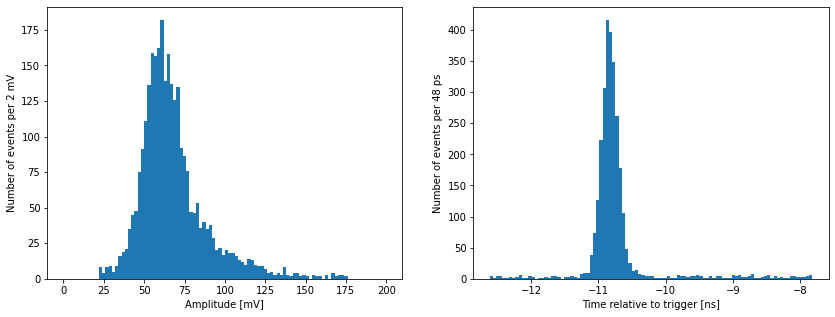

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist (data['amplitude'], bins = np.linspace(0, 200, 101))
plt.xlabel("Amplitude [mV]")
plt.ylabel("Number of events per 2 mV")
plt.subplot(1,2,2)
_, bins, _ = plt.hist (data['time'], bins =  100)# np.linspace(-11.5, -9.0, 61))
plt.xlabel("Time relative to trigger [ns]")
plt.ylabel(f"Number of events per {(bins[1]-bins[0])*1000:.0f} ps")

plt.show()

## Costruzione del modello per il ritardo

Costruire un modello di fit per il ritardo che includa:    
 * una gaussiana per rappresentare il picco di eventi "in coincidenza"
 * un fondo piatto per rappresentare gli eventi casuali

Sia la normalizzazione analitica che numerica delle *pdf* sono perfettamente accettabili per questo esercizio.

Inoltre, definire la *extended negative log-likelihood* per il modello descritto.

In [ ]:
class Model:
  def __init__ (self, data, range):
    self.data = data[(data > range[0]) & (data < range[1])].astype (np.float64)
    self.range = range

  def signal (self, x, mean, sigma):
    return np.exp (-0.5 * (x-mean)**2/sigma**2)/np.sqrt(2*np.pi)/sigma

  def background (self, x):
    normalization = range[1] - range[0]
    return np.ones_like(x)/ normalization

  def model (self, x, nS, nB, mean, sigma):
    s = self.signal (x, mean, sigma)
    b = self.background (x)
    f = nS/(nS+nB)
    return f*s + (1-f)*b

  def nll (self, nS, nB, mean, sigma):
    x = self.data
    return nS + nB - np.sum(np.log((nS+nB)*self.model(x, nS, nB, mean, sigma)))

Verificare che il modello sia normalizzato. Verificare prima le componenti di segnale e fondo separatamente, e poi la somma pesata delle due.

In [ ]:
range = (-12, -9)
model = Model (data['time'].values, range)
xAxis = np.linspace (range[0], range[1], 1000)

print ("Signal Normalization: ", np.trapz(model.signal(xAxis, -10, 0.1), xAxis))
print ("Background Normalization: ", np.trapz(model.background(xAxis), xAxis))
print ("Full Model Normalization: ", np.trapz(model.model(xAxis, 100, 10, -10, 0.1), xAxis))

Signal Normalization:  1.0000000000000002
Background Normalization:  0.9999999999999998
Full Model Normalization:  1.0000000000000002


## Fit non-binnato di massima *likelihood* estesa

Utilizzando il modello definito sopra, eseguire il fit della variabile `time` del dataset utilizzando l'algoritmo `MIGRAD`.

La *deviazione standard del picco gaussiano* è la risoluzione del sensore al diamante e rappresenta un primo importante risultato di questa analisi.

In [ ]:
m = Minuit(model.nll, nS=0.9*len(data), nB=0.02*len(data), mean=-10, sigma=0.1)
m.errordef = 0.5
m.errors = [0.1, 0.1, 0.1, 0.1]
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.996e+04                 │              Nfcn = 145              │
│ EDM = 7.11e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nS    │  2.54e3   │  0.05e3   │            │            │         │         │       │
│ 1 │ nB    │    200    │    17     │            │            │         │         │       │
│ 2 │ mean  │ -10.8293  │  0.0026   │            │            │         │         │       │
│ 3 │ sigma │  0.1233   │  0.0020   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │        nS        nB      mean     sigma │
├───────┼─────────────────────────────────────────┤
│    nS │  2.63e+03     -85.8  0.000666    0.0071 │
│    nB │     -85.8       286 -0.000665  -0.00709 │
│  mean │  0.000666 -0.000665  6.52e-06  1.22e-07 │
│ sigma │    0.0071  -0.00709  1.22e-07  4.11e-06 │
└───────┴─────────────────────────────────────────┘

## Rappresentare graficamente l'esito del fit

Sovrapporre il modello definito sopra, con i parametri ottenuti dal fit, all'istogramma della variabile `time`.

Text(0.5, 1.0, 'Resolution: 123.3 ps')

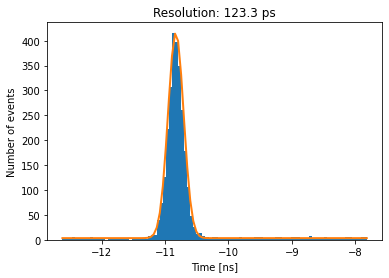

In [ ]:
contents, bins, _ = plt.hist(data['time'], bins = 100)
binw = bins[1] - bins[0]
plt.plot(bins, model.model(bins, *m.values)*binw*contents.sum(), linewidth=2)
plt.xlabel ("Time [ns]")
plt.ylabel ("Number of events")
plt.title (f"Resolution: {m.values['sigma']*1e3:.1f} ps")

## Fit in bin di ampiezza

Suddividere il dataset in bin di ampiezza con *boundaries*:
40, 50, 60, 70, 80, 100 e 120 mV.

Per ciascun bin, ripetere la procedura di *fit* salvando in una lista il valore della risoluzione e l'errore ottenuto dal Minuit.

> **Suggerimento**: Per agevolare la convergenza dei diversi fit, può essere una buona idea inizializzare i parametri ai valori ottenuti sul fit precedente, ottenuto con l'intero spettro di ampiezza.


In [ ]:
amplitude_boundaries = [50, 60, 70, 80, 100, 120]
amplitude = []
amplitude_error = []
resolution = []
resolution_error = []

for amin, amax in zip(amplitude_boundaries[:-1], amplitude_boundaries[1:]):
  bin_data = data.query(f"amplitude > {amin} and amplitude < {amax}")['time']
  model = Model (bin_data.values, range)

  bm = Minuit(model.nll,
              nS=0.98*len(bin_data),
              nB=0.02*len(bin_data),
              mean=m.values['mean'],
              sigma=m.values['sigma'])
  bm.errordef = 0.5
  bm.migrad()

  amplitude.append ((amin+amax)/2)
  amplitude_error.append ((amax-amin)/2)

  resolution.append (bm.values['sigma'])
  resolution_error.append (bm.errors['sigma'])

Infine, rappresentare graficamente il risultato mostrando il variare della risoluzione temporale in funzione dell'ampiezza.

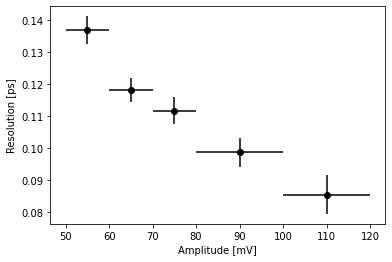

In [ ]:
plt.errorbar (amplitude, resolution, resolution_error, amplitude_error, 'ko')
plt.xlabel ("Amplitude [mV]")
plt.ylabel ("Resolution [ps]")
plt.show()

## Conclusioni
In questo tema abbiamo studiato la risoluzione temporale di un rivelatore al diamante da un dataset raccolto in un test su fascio.

Inoltre abbiamo valutato come la risoluzione temporale dipende dall'ampiezza.